In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Problem 2

### Problem statement: 

Want to know how large $n$ has to be so that the Poisson distribution and Gaussian distribution agree to within a factor of 2 at $5\sigma$ and at $3\sigma$

### Strategy: 

Write the Poisson and Gaussian distributions in terms of the same variables. I'll write it all in terms of $\lambda$, the mean: so for the Gaussian distribution, $\sigma \rightarrow \sqrt{\lambda}$. To agree within a factor of two at $a\sigma$, the following equality should hold:

$$ \frac{P(\lambda + a\sqrt{\lambda})}{G(\lambda + a\sqrt{\lambda})} = 2  $$

Where P is the poisson distribution:

$$ P(x) = \frac{\lambda^x e^{-\lambda}}{x!} $$

And G is the Gaussian distribution:

$$ G(x) = \frac{e^{-\frac{(x-\lambda)^2}{2\lambda}}}{\sqrt{2\pi\lambda}} $$

Now, to make things computationally more simple, we will make Sterling's approximation and take the natural logarithm. So, the equality turns to:

$$ \left(x\ln{\lambda} - \lambda + x - x\ln{x} - \frac{1}{2}\ln{2\pi x}\right) - \left(-\frac{(x-\lambda)^2}{2\lambda} - \frac{1}{2}\ln{2\pi x}\right) = \ln{2} $$

By evaluating LHS of the equation for many values of $\lambda$, an approximation may be found for the $\lambda$ (assuming $n$ is of the order $\lambda$) which gives at least a factor of 2 agreement for the Poisson and Gaussian at $5\sigma$ and $3\sigma$.

Create a function for the ln of the Poisson distribution:

In [2]:
def ln_poisson(x,lam):
    return (x*np.log(lam) - lam + x - x*np.log(x) - 0.5*np.log(2*np.pi*x))

And for the ln of the Gaussian distribution:

In [3]:
def ln_gaussian(x,lam,sigma):
    return (-((x - lam)**2/(2*lam)) - 0.5*np.log(2*np.pi*lam))

1000 Values of $\lambda$ from very close to 0 to 1000, giving approximate integer $\lambda$.

In [4]:
lam = np.linspace(0.1,1000,num=1000)
five_sigma = lam + 5*np.sqrt(lam)
three_sigma = lam + 3*np.sqrt(lam)

Plot a figure to see where the LHS and RHS of the equation intersect

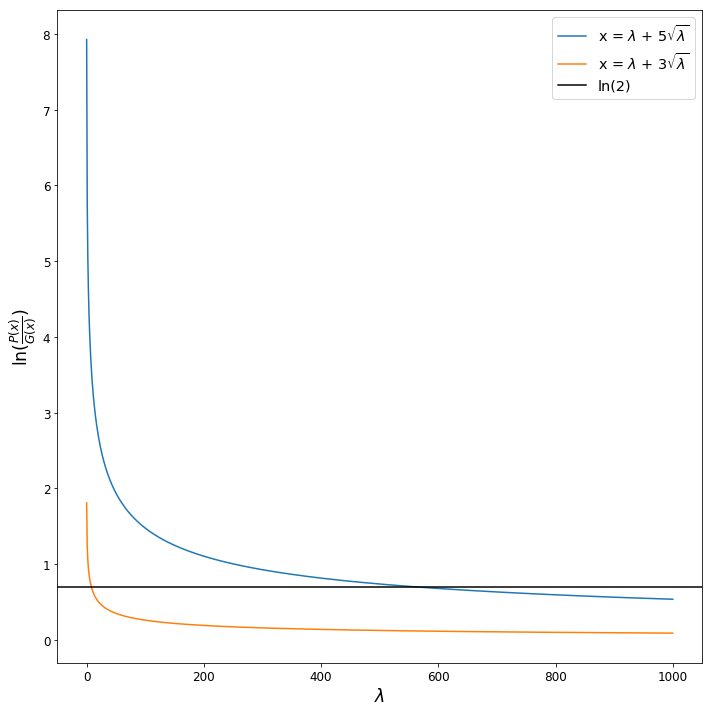

In [5]:
fig = plt.figure(figsize=(10,10))
plt.plot(lam,ln_poisson(five_sigma,lam)-ln_gaussian(five_sigma,lam,np.sqrt(lam)),
         label='x = $\lambda$ + 5$\sqrt{\lambda}$')
plt.plot(lam,ln_poisson(three_sigma,lam)-ln_gaussian(three_sigma,lam,np.sqrt(lam)),
         label='x = $\lambda$ + 3$\sqrt{\lambda}$')
plt.axhline(np.log(2),c='k',label='ln(2)')
plt.legend(fontsize='x-large')
plt.xlabel('$\lambda$',fontsize='xx-large')
plt.ylabel(r'ln($\frac{P(x)}{G(x)}$)',fontsize='xx-large')
plt.tick_params(labelsize='large')
plt.tight_layout()
plt.show()

Find out the value of $\lambda$ where the curves intersect, giving the order $n$ for which the Poisson agrees with the Gaussian to within a factor of 2.

In [6]:
difference_5 = abs(ln_poisson(five_sigma,lam)-ln_gaussian(five_sigma,lam,np.sqrt(lam)) - np.log(2))
idx_min_5 = np.argmin(difference_5)

difference_3 = abs(ln_poisson(three_sigma,lam)-ln_gaussian(three_sigma,lam,np.sqrt(lam)) - np.log(2))
idx_min_3 = np.argmin(difference_3)

print('To agree to a factor of two at 5sigma, require n = %s' % str(int(lam[idx_min_5])+1))
print('To agree to a factor of two at 3sigma, require n = %s' % str(int(lam[idx_min_3])+1))

To agree to a factor of two at 5sigma, require n = 576
To agree to a factor of two at 3sigma, require n = 9


# Problem 5

### Problem Statement

Write a program to generate random Gaussian noise. Add a template to it (I will use a Gaussian template). Fit an amplitude and error to each individual chunk (multiple noisy 'observations'), then use that to get an overall amplitude and error. Need to estimate the noise by assuming it's constant and equal to the scatter in the observed data (take the standard deviation of each 'observation')

In [7]:
def gaussian(x,mu,sigma):
    num = np.exp(-(x-mu)**2/(2*sigma**2))
    den = np.sqrt(2*np.pi*sigma**2)
    return num/den

1000 data points, 20 observations, true noise of 0.3, true amplitude of 3.0, template mean of 0 and std of 1

In [8]:
n = 1000
n_obs = 100
noise = np.random.randn(n_obs,n)*0.3
amp_true = 3.0
sigma = 1.0
x = np.linspace(-10,10,n)
template = gaussian(x,0,sigma)
template_arr = np.tile(template,(n_obs,1))
data = template_arr*amp_true + noise

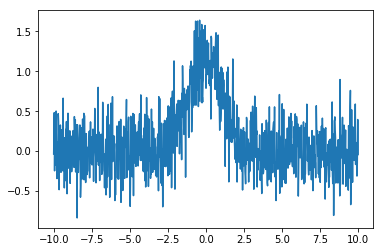

In [9]:
plt.plot(x,data[0])
plt.show()

Loop through each 'observation' and make a noise estimate by taking the std of the observation. Obviously this is going to be biased - our template is a gaussian, and so the points around the peak are going to bias the noise high ($\bar{x}$ when taking the standard deviation will be above 0, while the true average of our added noise is 0, it's just the template that throws it off). However, as a first pass, it should be acceptable for fitting purposes. For each noise estimate, assuming uncorellated noise, we can solve the equation

$$ m = \frac{A^T N^{-1} d}{A^T N^{-1} A} $$

To find the amplitude. I have made the assumption we know the center of our distribution, so there is no filtering going on and I simply recover a value for my amplitude instead of a curve.

In [10]:
amp = np.zeros(n_obs)
err = np.zeros(n_obs)
Ninv = np.zeros(n_obs)
data_filt = np.zeros((n_obs,n))
denom = np.zeros(n_obs)
for i in range(n_obs):
    err[i] = np.std(data[i])
    Ninv[i] = err[i]**-2
    data_filt[i,:] = data[i]*Ninv[i]
    denom[i] = np.dot(template,Ninv[i]*template)
    rhs = np.dot(template,data_filt[i])
    amp[i] = rhs/denom[i]

Calculate the weighted average of the amplitude and error

In [11]:
amp_avg = np.sum(Ninv*amp)/np.sum(Ninv)
err_avg = np.sum(Ninv*err)/np.sum(Ninv)

Plot the error vs. amplitude to see how our error estimation affects our amplitude fit. There is a correlation between the fitted amplitude and the estimated error, which leads me to believe that the least square estimate for a given chunk is biased based on the estimated error rather than unbiased, but I'm just not sure how to quantify that honestly.

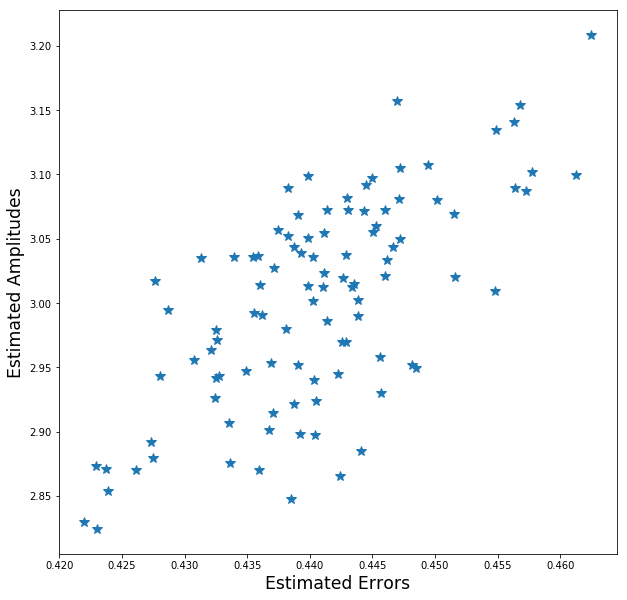

In [12]:
plt.figure(figsize=(10,10))
plt.xlabel('Estimated Errors',fontsize='xx-large')
plt.ylabel('Estimated Amplitudes',fontsize='xx-large')
plt.plot(err,amp,'*',markersize=10)
plt.show()

Plot the average amplitude and estimated error with a scatterplot of fit amplitudes and estimated errors, with the 'true' values also shown. The average amplitude ended up actually seeming biased high, but I'm not sure if that's because I made an error when calculating the average or if I just didn't make enough 'observations'. As well, clearly the estimated noise spread is higher than the actual, due to the fact we took a standard deviation without any sort of subtracted template.

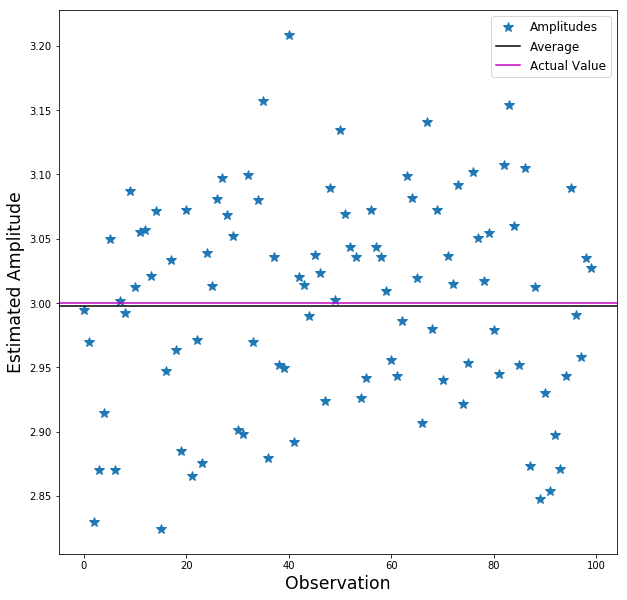

In [13]:
plt.figure(figsize=(10,10))
plt.plot(amp,'*',markersize=10,label='Amplitudes')
plt.ylabel('Estimated Amplitude',fontsize='xx-large')
plt.xlabel('Observation',fontsize='xx-large')
plt.axhline(amp_avg,c='k',label='Average')
plt.axhline(3,c='m',label='Actual Value')
plt.legend(loc='best',fontsize='large')
plt.show()

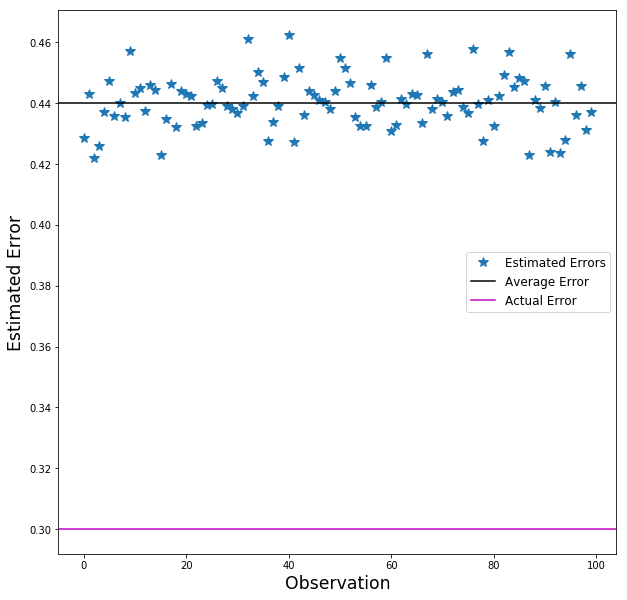

In [14]:
plt.figure(figsize=(10,10))
plt.plot(err,'*',markersize=10,label='Estimated Errors')
plt.ylabel('Estimated Error',fontsize='xx-large')
plt.xlabel('Observation',fontsize='xx-large')
plt.axhline(err_avg,c='k',label='Average Error')
plt.axhline(0.3,c='m',label='Actual Error')
plt.legend(loc='best',fontsize='large')
plt.show()

One way to mitigate the error estimate would be to somehow subtract a template from the data, and be left with only noise, so the standard deviation estimate of the constant noise would be more accurate. Perhaps this could be done by making the initial noise estimate, fitting the template, subtracting said template from the data, and then estimating the noise again and fitting a better amplitude. But this seems like a process that could just be done recursively, and just doesn't feel right to me.